In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import nn_utils

torch.cuda.empty_cache()

PATH = './nn-models/cifar10-nn-model'

# load the pretrained NN model
net = nn_utils.Net()
net.load_state_dict(torch.load(PATH))
net.to(device=nn_utils.DEVICE)

# nn_utils.test_nn(net=net)

NSGA-II

In [4]:
import random
import numpy as np
from deap import base, creator, tools
import matplotlib.pyplot as plt

nn_utils.freeze_parameters(net=net)

# hyperparameters
MIN_BOUND = 0.0
MAX_BOUND = 1.0
N_DIMENSIONS = sum(param.numel() for param in net.out.parameters())
N_BITS = 10
N_GENERATIONS = 175
MU = 200
CX_PB = 0.9
UNIFORM_CX_PB = 0.5
MUTATE_PB = 0.1
MUTATE_FLIP_PB = 1.0 / (N_DIMENSIONS * N_BITS)

# store all the training dataset in a single list
ALL_IMAGES = []
ALL_LABELS = []
for images, labels in nn_utils.TRAINLOADER:
    ALL_IMAGES.append(images)
    ALL_LABELS.append(labels)

def decode(individual):
    real_numbers = []
    for i in range(N_DIMENSIONS):
        chromosome = individual[i*N_BITS:(i+1)*N_BITS]
        bit_string = ''.join(map(str, chromosome))
        num_as_int = int(bit_string, 2) # convert to int from base 2 list
        num_in_range = MIN_BOUND + (MAX_BOUND - MIN_BOUND) * num_as_int / 2**N_BITS
        real_numbers.append(num_in_range)

    return real_numbers

# loss function
def f1(individual, mini_batch_num):
    # put the parameters in the neural network
    parameters = decode(individual=individual)
    parameters = torch.as_tensor(parameters, dtype=torch.float32, device=nn_utils.DEVICE)
    net.out.weight = torch.nn.Parameter(data=parameters[0:640].reshape(10, 64))
    net.out.bias = torch.nn.Parameter(data=parameters[640:650])

    with torch.no_grad():
        images, labels = ALL_IMAGES[mini_batch_num].to(nn_utils.DEVICE), ALL_LABELS[mini_batch_num].to(nn_utils.DEVICE)

        preds = net(images) # forward mini-batch
        loss = F.cross_entropy(preds, labels) # calculate loss

    return loss.item()

# Gaussian regulariser (sum of the square of the weights)
def f2():
    weight = net.out.weight.reshape((10, 64)).flatten().tolist()
    bias = net.out.bias.flatten().tolist()

    squared_weight = [w**2 for w in weight]
    squared_bias = [b**2 for b in bias]

    return sum(squared_weight) + sum(squared_bias)

def calculate_fitness(individual, mini_batch_num):
    return (f1(individual=individual, mini_batch_num=mini_batch_num), f2())

creator.create('FitnessMin', base.Fitness, weights=(-1.0, -1.0))
creator.create('Individual', list, fitness=creator.FitnessMin)

toolbox = base.Toolbox()

toolbox.register('attr_bool', random.randint, 0, 1)
toolbox.register('individual', tools.initRepeat, creator.Individual, toolbox.attr_bool, N_BITS*N_DIMENSIONS)
toolbox.register('generate_population', tools.initRepeat, list, toolbox.individual)

toolbox.register('evaluate', calculate_fitness)
toolbox.register('crossover', tools.cxUniform, indpb=UNIFORM_CX_PB)
toolbox.register('mutate', tools.mutFlipBit, indpb=MUTATE_FLIP_PB)
toolbox.register('select', tools.selNSGA2)

def nsga_ii():
    pareto_front = tools.ParetoFront()

    # generate initial random population of individuals (parameters)
    population = toolbox.generate_population(n=MU)

    # evaluate the entire population
    fitnesses = list(map(toolbox.evaluate, population, np.zeros(len(population), dtype=int)))
    for ind, fit in zip(population, fitnesses):
        ind.fitness.values = fit

    # assign crowding distance, no actual selection is done
    population = toolbox.select(population, len(population))

    # track the performance of each generation
    best_individuals = []
    worst_individuals = []

    # begin the generational process
    for gen in range(0, N_GENERATIONS):

        # selection based on dominance (D) followed by crowding distance (CD)
        offspring = tools.selTournamentDCD(population, len(population))
        offspring = [toolbox.clone(ind) for ind in offspring]

        # crossover make pairs of all (even, odd) in offspring
        for ind1, ind2 in zip(offspring[::2], offspring[1::2]):
            if random.random() <= CX_PB:
                toolbox.crossover(ind1, ind2)
                del ind1.fitness.values
                del ind2.fitness.values

        # mutation
        for mutant in offspring:
            if random.random() <= MUTATE_PB:
                toolbox.mutate(mutant)
                del mutant.fitness.values

        # evaluate the individuals with an invalid fitness
        invalid_ind = [ind for ind in offspring if not ind.fitness.valid]
        fitnesses = map(toolbox.evaluate, invalid_ind, np.full(len(invalid_ind), gen % len(ALL_IMAGES), dtype=int))
        for ind, fit in zip(invalid_ind, fitnesses):
            ind.fitness.values = fit

        # select the next generation population
        population = toolbox.select(population + offspring, MU)

        # update the pareto front
        pareto_front.update(population=population)

        population.sort(key=lambda x: x.fitness.values)
        best_individuals.append(population[0].fitness.values)
        worst_individuals.append(population[-1].fitness.values)

        print(f'Generation: {gen} -- Best individual: {best_individuals[-1]} - Worst individual: {worst_individuals[-1]}')

    return population, pareto_front, best_individuals, worst_individuals

population, pareto_front, best_individuals, worst_individuals = nsga_ii()

/user/HS400/sr01303/.local/lib/python3.10/site-packages/deap/creator.py:185: RuntimeWarning: A class named 'FitnessMin' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
/user/HS400/sr01303/.local/lib/python3.10/site-packages/deap/creator.py:185: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "


Generation: 0 -- Best individual: (6.927978515625, 209.95435619354248) - Worst individual: (25.45379638671875, 201.9606475830078)
Generation: 1 -- Best individual: (6.927978515625, 209.95435619354248) - Worst individual: (25.45379638671875, 201.9606475830078)
Generation: 2 -- Best individual: (6.927978515625, 209.95435619354248) - Worst individual: (22.838422775268555, 192.24395084381104)
Generation: 3 -- Best individual: (6.7596635818481445, 195.5306634902954) - Worst individual: (22.838422775268555, 192.24395084381104)
Generation: 4 -- Best individual: (6.1406683921813965, 213.89471530914307) - Worst individual: (20.08344841003418, 192.0019407272339)
Generation: 5 -- Best individual: (5.527289390563965, 200.32037544250488) - Worst individual: (24.183034896850586, 186.03228759765625)
Generation: 6 -- Best individual: (5.527289390563965, 200.32037544250488) - Worst individual: (21.406749725341797, 183.72070503234863)
Generation: 7 -- Best individual: (5.4922637939453125, 209.3618526458

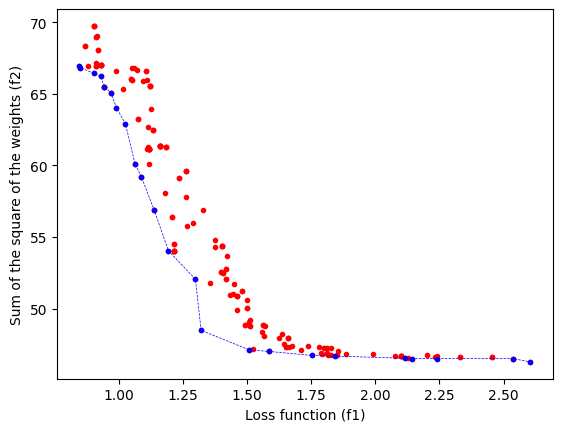

In [24]:
# plot final population
front = np.array([ind.fitness.values for ind in population])
# plot pareto frontier
pareto = np.array([ind.fitness.values for ind in pareto_front])
# label each point from the pareto frontier
# for i in range(len(pareto)):
#     x = pareto[i][0]
#     y = pareto[i][1]
#     plt.text(x * (1 - 0.07), y * (1 + 0.01) , i, fontsize=10)

plt.scatter(front[:,0], front[:,1], c='r', marker='.')
plt.scatter(pareto[:,0], pareto[:,1], c='b', marker='.')
plt.plot(pareto[:,0], pareto[:,1], c='b', linewidth='0.5', linestyle='dashed')
plt.axis('tight')
plt.xlabel('Loss function (f1)')
plt.ylabel('Sum of the square of the weights (f2)')
plt.show()

In [6]:
for solution, solution_fitness in zip(pareto_front.items, pareto_front.keys):
    # put parameters back into the neural network
    parameters = torch.as_tensor(decode(solution), dtype=torch.float32, device=nn_utils.DEVICE)
    net.out.weight = torch.nn.Parameter(data=parameters[0:640].reshape(10, 64))
    net.out.bias = torch.nn.Parameter(data=parameters[640:650])
    print(f'Fitness: {solution_fitness} --  Accuracy: {nn_utils.test_nn(net=net)}') 

Fitness: (2.6044833660125732, 46.27052879333496) --  Accuracy: 56
Fitness: (2.5369625091552734, 46.50288200378418) --  Accuracy: 57
Fitness: (2.241706132888794, 46.503485679626465) --  Accuracy: 55
Fitness: (2.144752025604248, 46.505577087402344) --  Accuracy: 55
Fitness: (2.114084005355835, 46.5273323059082) --  Accuracy: 53
Fitness: (1.842682123184204, 46.678587913513184) --  Accuracy: 54
Fitness: (1.7539786100387573, 46.721861839294434) --  Accuracy: 54
Fitness: (1.584122896194458, 47.00629138946533) --  Accuracy: 53
Fitness: (1.5081110000610352, 47.11209297180176) --  Accuracy: 51
Fitness: (1.3208621740341187, 48.47657108306885) --  Accuracy: 51
Fitness: (1.2984707355499268, 52.054168701171875) --  Accuracy: 47
Fitness: (1.193445086479187, 54.03815746307373) --  Accuracy: 47
Fitness: (1.1378973722457886, 56.881452560424805) --  Accuracy: 46
Fitness: (1.08767569065094, 59.21138858795166) --  Accuracy: 45
Fitness: (1.0631685256958008, 60.11454391479492) --  Accuracy: 39
Fitness: (1.0